## Energy consumption predictions 
The goal is here to predict energy consumption of non-residential seattle buildings. 

To do that I will   : 

- I. Split my data into train and test sets. Work on feature engineering  while assuring no memory leakage
- II. Fit my model hyper-parameters on the training data 
- III. Select the most appropriate model based on **R2 score** and **inference time**
- IV. Study the interpretability of the selected model

All the feature transformation and model fitting is the same process for carbon emission prediction. I will try to define as much as possible functions do not duplicate code in the second notebook.  

In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import stats

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn import dummy

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold 
from sklearn.metrics import  r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor 

import warnings
warnings.filterwarnings("ignore")
import shap


In [2]:
# load dataset than has been clean in the cleanUp notebook 
pData = pd.read_csv('prediction.csv')

In [3]:
pData.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,...,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,SteamUsed,ElectricityUsed,NaturalGasUsed
0,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,...,0.0,NoNe,0.0,60.0,7226362.5,249.98,2.83,True,True,True
1,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,...,15064.0,Restaurant,4622.0,61.0,8387933.0,295.86,2.86,False,True,True
2,5,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,...,0.0,NoNe,0.0,56.0,6794584.0,286.43,4.67,True,True,True
3,10,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61390,-122.33283,1926,1.0,...,0.0,NoNe,0.0,27.0,5758795.0,176.14,2.12,False,True,True
4,11,NonResidential,Other,98101.0,7,DOWNTOWN,47.61327,-122.33136,1926,1.0,...,0.0,NoNe,0.0,75.0,6298131.5,221.51,2.16,True,True,True


The data still contains non numerical variables such as *BuildingType*. Regression models take only numerical variables so I need to process them beforehand. 

In [4]:
def getCategoricalVariables(): 
    return ['ZipCode','NumberofBuildings','NumberofFloors','CouncilDistrictCode']

def getObjectList(data): 
    objectlist = []
    for k in range(len(data.dtypes)): 
        if data.dtypes[k] == object : 
            objectlist.append(data.dtypes.index[k])
    return objectlist   


def getBoolList(data): 
    boolList = []
    for k in range(len(data.dtypes)): 
        if data.dtypes[k] == bool : 
            boolList.append(data.dtypes.index[k])
    return boolList   

In [5]:

objectlist  = getObjectList(pData)
catList     = getCategoricalVariables()
objectlist  = getObjectList(pData)
boolList    = getBoolList(pData)

print("columns of object type : ", objectlist)
print("columns of object bool : ", boolList)


columns of object type :  ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']
columns of object bool :  ['SteamUsed', 'ElectricityUsed', 'NaturalGasUsed']


I need to handle non numeric variables input for my model. As transforms needs to be based **on training data only**. 
Let's first separate the two. 


# I. Train/Test split and feature engineering 

I split the data into 30% testing set and 70% of training set. 

In [6]:
tData = pData.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions','GHGEmissionsIntensity','OSEBuildingID','ENERGYSTARScore'])

column_sels = list(tData.columns)
X = tData.loc[:,column_sels]
X = pd.DataFrame(data=X, columns=column_sels)
Y = pData['SiteEnergyUse(kBtu)']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=.3, # 30% de test
                                                    random_state =123) # toujours le même spilt 
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)


(959, 22)
(959,)
(412, 22)
(412,)


I choose to transform categorical variable into quantitative one through **Target encoding**. Delete previous one from the dataset. 
I avoid **target leakage** by doing target encoding only on training data and then I apply it to test data. 
Some modality might not have been encountered during traning. For these cases, I will take the median value as encoded value.

In [7]:
def TargetEncodingObjectlist(X_train, X_test, y_train,objectlist,target):
    train = pd.concat([X_train, y_train], axis=1)

    for col in objectlist: 
        new_name = str(col) + "_encoded"
        target_encoding = train.groupby(col).mean()[target]
        X_train[new_name] = X_train[col].map(target_encoding)
        X_test[new_name] = X_test[col].map(target_encoding)
        # Handle residual : some testing set modality might not have been encountered is the training set
        # therefore I will take the median value for these cases
        X_test.loc[X_test[new_name].isna(), new_name]  = train.mean()[target]

    X_train.drop(columns=objectlist,inplace=True)
    X_test.drop(columns=objectlist,inplace=True)
    X_test.head()
    return X_train, X_test
X_train, X_test = TargetEncodingObjectlist(X_train, X_test, y_train,catList + objectlist + boolList,'SiteEnergyUse(kBtu)')

To improve model performance, I choose to incorporate **new variables** that link the type of usage to the surface.

The property use type encoded by target encoding is multiplied by the corresponding GFA (surface) for Largest, second and third use type and normalized by the total property GFA. 

In [8]:
def TypeByGFA(X_train,X_test):
    X_train['LargestPropertyUseType_byGFA']       = X_train.apply( lambda x : ( x.LargestPropertyUseType_encoded        *  x.LargestPropertyUseTypeGFA) / x.PropertyGFATotal,axis=1 )
    X_train['SecondLargestPropertyUseType_byGFA'] = X_train.apply( lambda x : ( x.SecondLargestPropertyUseType_encoded  *  x.SecondLargestPropertyUseTypeGFA )/ x.PropertyGFATotal,axis=1) 
    X_train['ThirdLargestPropertyUseType_byGFA']  = X_train.apply( lambda x : ( x.ThirdLargestPropertyUseType_encoded   *  x.ThirdLargestPropertyUseTypeGFA )  / x.PropertyGFATotal,axis=1 )

    X_test['LargestPropertyUseType_byGFA']       = X_test.apply( lambda x : ( x.LargestPropertyUseType_encoded        *  x.LargestPropertyUseTypeGFA) / x.PropertyGFATotal,axis=1 )
    X_test['SecondLargestPropertyUseType_byGFA'] = X_test.apply( lambda x : ( x.SecondLargestPropertyUseType_encoded  *  x.SecondLargestPropertyUseTypeGFA )/ x.PropertyGFATotal,axis=1) 
    X_test['ThirdLargestPropertyUseType_byGFA']  = X_test.apply( lambda x : ( x.ThirdLargestPropertyUseType_encoded   *  x.ThirdLargestPropertyUseTypeGFA )  / x.PropertyGFATotal,axis=1 )
    return X_train,X_test
X_train,X_test = TypeByGFA(X_train,X_test)

As I have seen in the exploratory notebook, I do not want to take seasonality of the consumption of electricity per YearofBuilt into account.  I consider the seasonality as noise in this temporal series. Therefore I proceed on a polynomial regression only on training data. By doing that I only take the trend into account. I create a **new variable** associated to this process called **YearBuildTrend**. For test data,  I use coefficient of the former fitted training data. 

In [9]:
def AddYearBuildTrend(X_train, X_test, y_train,target) : 
    train = pd.concat([X_train, y_train], axis=1)
    meanYearConsumption= train.groupby("YearBuilt")[target].mean()
    X = meanYearConsumption.index.values.reshape(-1, 1)
    # PolynomialFeatures generate a new feature matrix consisting of all polynomial combinations (1,x**2,x**3)
    poly = PolynomialFeatures(degree = 3)
    model = LinearRegression().fit(poly.fit_transform(X), meanYearConsumption)
    polynomialYear  = poly.fit_transform(X_train['YearBuilt'].values.reshape(-1, 1)) # transform x to (1,x,x2,x3)
    X_train['YearBuilt_trend'] = model.predict(polynomialYear)
    X_test['YearBuilt_trend'] = model.predict(poly.transform(X_test['YearBuilt'].values.reshape(-1, 1)))
    X_train.drop('YearBuilt',axis=1,inplace=True)
    X_test.drop('YearBuilt',axis=1,inplace=True)
    return X_train, X_test

X_train, X_test = AddYearBuildTrend(X_train, X_test, y_train,'SiteEnergyUse(kBtu)')

Let's plot some variables and look at there distribution : 

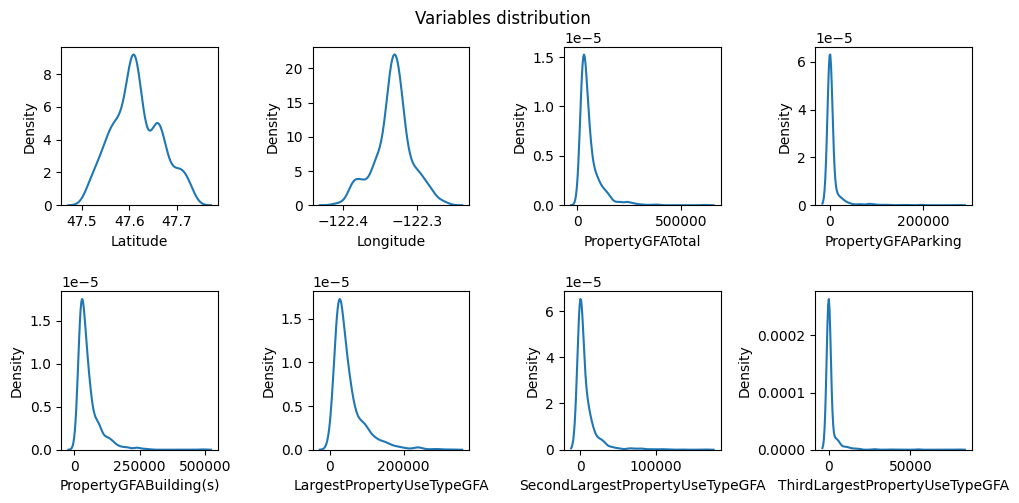

In [10]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(10, 5))
index = 0
axs = axs.flatten()
for i, k in enumerate(X_train.columns[:8]):
    sns.kdeplot(data=X_train, x=k, ax=axs[i])
fig.suptitle("Variables distribution")
plt.tight_layout(pad=0.5, w_pad=0.6, h_pad=2.0)
plt.show()

Our variables do not seem to have a normal distribution. Having variables that are normally distributed will improve our regression performances.
I choose to apply **Box-Cox transform** for variables that are skewed. 

All variables are continuous and can be applied a **boxcox transform** if **the skewness** is above a graphically determined threshold. 


In [11]:
def getskeId_columns(X_train,v):
    skeId_columns = []
    for col in X_train.columns:
        if v >= 1 :
            print(f"{col:<40}", round(X_train[col].skew(),3))
        if X_train[col].skew() > 3 :
            skeId_columns.append(col)
    return skeId_columns
skeId_columns = getskeId_columns(X_train,1)

Latitude                                 0.221
Longitude                                -0.192
PropertyGFATotal                         3.271
PropertyGFAParking                       6.356
PropertyGFABuilding(s)                   2.907
LargestPropertyUseTypeGFA                2.332
SecondLargestPropertyUseTypeGFA          4.322
ThirdLargestPropertyUseTypeGFA           8.267
ZipCode_encoded                          0.993
NumberofBuildings_encoded                12.314
NumberofFloors_encoded                   2.072
CouncilDistrictCode_encoded              0.192
BuildingType_encoded                     9.507
PrimaryPropertyType_encoded              1.608
Neighborhood_encoded                     0.35
LargestPropertyUseType_encoded           1.255
SecondLargestPropertyUseType_encoded     1.471
ThirdLargestPropertyUseType_encoded      5.181
SteamUsed_encoded                        4.528
ElectricityUsed_encoded                  -30.968
NaturalGasUsed_encoded                   -0.878
LargestPr

In [12]:
skeId_columns

['PropertyGFATotal',
 'PropertyGFAParking',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'NumberofBuildings_encoded',
 'BuildingType_encoded',
 'ThirdLargestPropertyUseType_encoded',
 'SteamUsed_encoded',
 'ThirdLargestPropertyUseType_byGFA']

In [13]:
def BoxCoxTransform(X_train, X_test,skeId_columns,save_lambdas) : 
    for col in skeId_columns : 
        new_name = col + "_boxTrf"
        X_train.loc[X_train[col] == 0 , col] = 0.0000001
        X_test.loc[X_test[col] == 0 , col] = 0.0000001
        # transform training data & save lambda value
        X_train[new_name],fitted_lambda = stats.boxcox(X_train[col].values)
        save_lambdas.append(fitted_lambda)
        # use lambda value to transform test data
        X_test[new_name] = stats.boxcox(X_test[col].values, fitted_lambda)
    return X_train, X_test,save_lambdas
          
save_lambdas = []    
X_train, X_test,save_lambdas = BoxCoxTransform(X_train, X_test,skeId_columns,save_lambdas)

Let's display Box-Cox transform for three concerned variables

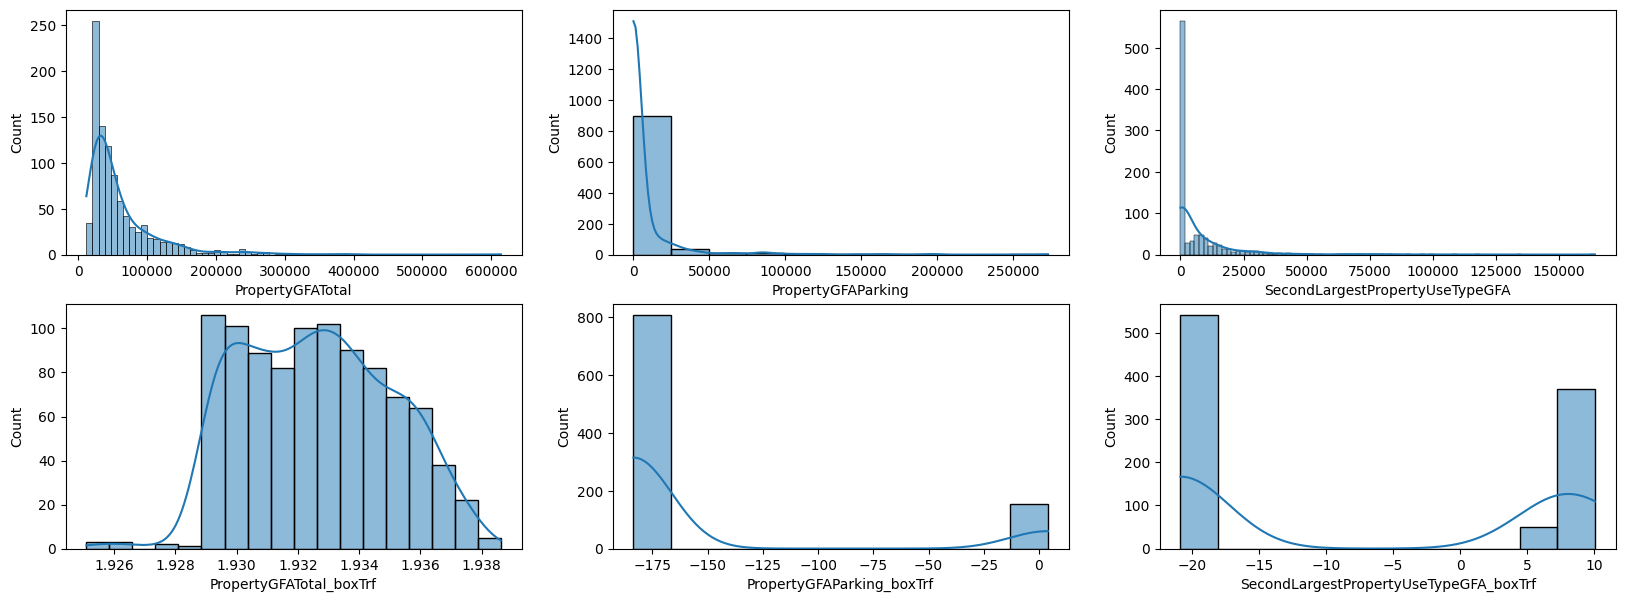

In [14]:
skeId_columns_trf = [ (col + "_boxTrf") for col in  skeId_columns ] 
fig, axs = plt.subplots(2, 3, figsize=(20, 7))
for j in range(3):
    sns.histplot(data=X_train, x=skeId_columns[j],  kde=True, ax=axs[0, j])
    sns.histplot(data=X_train, x=skeId_columns_trf[j],  kde=True, ax=axs[1, j])
    #axs[1, j].text(0.2, 0.01,str(round(save_lambdas[j],3)))
plt.show()

In [15]:
def  dropBoxCoxColumns(X_train,X_test,skeId_columns):
    # Drop column before transformation
    X_train.drop(columns=skeId_columns ,inplace=True)
    X_test.drop(columns=skeId_columns  ,inplace=True)
    return X_train,X_test

In [16]:
X_train,X_test = dropBoxCoxColumns(X_train,X_test,skeId_columns)

## Normalization 

Normalizing data prevent feature domination linked to the scale, here I used **MinMax scaler** so my data is in range 0 to 1. I also tried the **Standard and Robust scalers** but MinMax gave better R2 score at linear regression.  

In [17]:
def MinMaxNorm(X_train,X_test): 
    scaler = MinMaxScaler()  # Standardization 
    X_train_scaled = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_scaled,columns=X_train.columns)

    X_test_scaled = scaler.transform(X_test)
    X_test  = pd.DataFrame(X_test_scaled,columns=X_test.columns)
    return X_train,X_test

In [18]:
def MinMaxNormTarget(y_train,y_test):
    scaler = MinMaxScaler()  # Standardization 
    y_train_scale = scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_train = pd.Series(y_train_scale.reshape(1,-1)[0],index=y_train.index)

    y_test_scale = scaler.transform(y_test.values.reshape(-1, 1))
    y_test = pd.Series(y_test_scale.reshape(1,-1)[0],index=y_test.index)
    return y_train,y_test


In [19]:
X_train,X_test = MinMaxNorm(X_train,X_test)
y_train,y_test = MinMaxNormTarget(y_train,y_test)

Here I will use **cross-validation** to fit my **hyperparameters** for the different models. 
I do that by distinguish 10 non-overlapping groups ( = folds ). To converge towards the best parameter I will re-iterate this k-folds selection 5 times, using RepeatedKFold. 

In [20]:
# define evaluation
cv = RepeatedKFold(n_splits=10, # number of k-folds
                    n_repeats=5,
                    random_state=1)# seed

train_score = {}
test_score = {}
training_time = {}
inference_time = {}

# II. Model hyperparameter fitting    

Each computed R2 score for each batch is saved.
The selected hyperparameter is the one achieving the highest r2 score over all batch (mean). 

### Regularized Linear regression : Lasso 

In [21]:
def fitLassoModel(X_train,y_train,cv):
    # create lasso model 
    lasso_model = Lasso()
    # grid search for lambda coefficients 
    # alpha = lambda parameter 
    alphas = np.logspace(-5, 2,20)
    test_lambdas_values =  {'alpha': alphas}

    lasso_grid_search = GridSearchCV(lasso_model, 
                                    test_lambdas_values, 
                                    scoring='r2',
                                    n_jobs=-1, # run procesors in // 
                                    cv=cv) # kfolds parameters

    # search for best lambda parameter
    result = lasso_grid_search.fit(X_train,y_train)

    # summarize result
    print('Best Score: %.5f' % result.best_score_)
    print('Best Hyperparameters: %s' % result.best_params_)#define model
    
    return result.best_params_.get('alpha')

In [22]:
LASSO_ALPHA  = fitLassoModel(X_train,y_train,cv)

Best Score: 0.59590
Best Hyperparameters: {'alpha': 0.00029763514416313193}


## Supervised non-linear model : Support Vector regression with RBF kernel

Most important parameter is Kernel type. Most used are linear, polynomial or gaussian

In [23]:
def fitKernelSVR(X_train, y_train,cv): 
    C_range = np.logspace(0,5, 5)
    gamma_range =  np.logspace(-7, -3, 4)
    param_grid = {'C': C_range, 'gamma': gamma_range}

    svr_rbf = SVR(kernel="rbf")

    svr_rbf_grid_search = GridSearchCV(svr_rbf, 
                                        param_grid, 
                                        scoring='r2',
                                        n_jobs=-1, # run processors in // 
                                        cv=cv) # kfolds parameters

    svr_rbf_grid_search.fit(X_train,y_train)

    print("The optimal parameters are {} with a score of {:.2f}".format(svr_rbf_grid_search.best_params_, svr_rbf_grid_search.best_score_))
    return svr_rbf_grid_search.best_params_.get('C') , svr_rbf_grid_search.best_params_.get('gamma')

In [32]:
KERNEL_SVR_C  , KERNEL_SVR_GAMMA     =  fitKernelSVR(X_train, y_train,cv)

The optimal parameters are {'C': 5623.413251903491, 'gamma': 4.641588833612772e-05} with a score of 0.59


## Ensemble methods : random forest

In [30]:
def fitRandomForest(X_train, y_train,cv):
    param_grid = {'n_estimators': [10,100,500,1000],
                'min_samples_split' : [2, 5, 10],
                'min_samples_leaf' : [1, 2, 4],
                'bootstrap' : [True, False],
                'max_depth': [2,5,7]}

    RF_model = RandomForestRegressor(oob_score=True)
    RF_grid_search = GridSearchCV(RF_model, 
                                param_grid, 
                                scoring='r2',
                                n_jobs=-1, # run processors in // 
                                cv=cv) # kfolds parameters


    RF_grid_search.fit(X_train, y_train)
    print(RF_grid_search.best_params_, RF_grid_search.best_score_)
    return RF_grid_search.best_params_


In [31]:
best_params =  fitRandomForest(X_train, y_train,cv) 


{'bootstrap': True, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1000} 0.5983226071043485


In [34]:
RF_MAX_DEPTH = best_params.get('max_depth')
RF_N  = best_params.get('n_estimators')
RF_BOOTSTRAP =  best_params.get('bootstrap')
RF_MIN_SAMPLE_LEAF =  best_params.get('bootstrap')
RF_MIN_SAMPLES_SPLIT= best_params.get('min_samples_split')

## III. Evaluation and validation   

Here, I compute R2 score both on training and testing set. I also compute the training and the inference time of each model.

In [40]:
from sklearn.metrics import mean_squared_error
rmse_score = {}

In [36]:
def getMeanExecutionTime(model,X_test,nb_test):
    start = time.time()
    for i in range(1,nb_test+1):
        model.predict(X_test.iloc[i].values.reshape(1, -1))
    stop = time.time()
    execution_time =  stop - start 
    return execution_time

In [37]:
def getTrainingTime(model,X_train,y_train):
    start = time.time()
    model.fit(X_train.values,y_train.values)
    stop = time.time()
    train_time =  stop - start 
    return train_time

In [41]:
nb_test = 100 
dum = dummy.DummyRegressor(strategy='mean').fit(X_train,y_train)
train_score['dummy'] =  r2_score(y_train,dum.predict(X_train))
test_score['dummy']  = r2_score(y_test,dum.predict(X_test))

rmse_score['dummy'] = mean_squared_error(y_test,dum.predict(X_test),squared=False)

training_time['dummy'] = getTrainingTime(dum,X_train,y_train)
inference_time['dummy'] =  getMeanExecutionTime(dum,X_test,nb_test)

In [42]:
reg = LinearRegression().fit(X_train,y_train)
train_score['LinearRegression'] =  r2_score(y_train,reg.predict(X_train))
test_score['LinearRegression']  = r2_score(y_test,reg.predict(X_test))

rmse_score['LinearRegression'] = mean_squared_error(y_test,reg.predict(X_test),squared=False)

training_time['LinearRegression'] = getTrainingTime(reg,X_train,y_train)
inference_time['LinearRegression'] =  getMeanExecutionTime(reg,X_test,nb_test)

In [43]:
lasso_model = Lasso(alpha=LASSO_ALPHA).fit(X_train,y_train)
train_score['Lasso']    = r2_score(y_train,lasso_model.predict(X_train))
test_score['Lasso']     = r2_score(y_test,lasso_model.predict(X_test))

rmse_score['Lasso'] = mean_squared_error(y_test,lasso_model.predict(X_test),squared=False)

training_time['Lasso'] = getTrainingTime(lasso_model,X_train,y_train)
inference_time['Lasso'] =  getMeanExecutionTime(lasso_model,X_test,nb_test)


svr_rbf = SVR(kernel="rbf",C= KERNEL_SVR_C,gamma=KERNEL_SVR_GAMMA).fit(X_train,y_train)
train_score['SVR_RBF']  = r2_score(y_train,svr_rbf.predict(X_train))
test_score['SVR_RBF']   = r2_score(y_test,svr_rbf.predict(X_test))

rmse_score['SVR_RBF'] = mean_squared_error(y_test,svr_rbf.predict(X_test),squared=False)

training_time['SVR_RBF'] = getTrainingTime(svr_rbf,X_train,y_train)
inference_time['SVR_RBF'] =  getMeanExecutionTime(svr_rbf,X_test,nb_test)



In [44]:

RF_model = RandomForestRegressor(oob_score=True,
                                 bootstrap =RF_BOOTSTRAP,
                                 min_samples_leaf=RF_MIN_SAMPLE_LEAF, 
                                 min_samples_split=RF_MIN_SAMPLES_SPLIT,
                                 n_estimators=RF_N,
                                 max_depth=RF_MAX_DEPTH).fit(X_train,y_train) # just for faster run 

train_score['RandomForest'] = r2_score(y_train,RF_model.predict(X_train))
test_score['RandomForest'] = r2_score(y_test,RF_model.predict(X_test))

rmse_score['RandomForest'] = mean_squared_error(y_test,RF_model.predict(X_test),squared=False)

training_time['RandomForest'] = getTrainingTime(RF_model,X_train,y_train)
inference_time['RandomForest'] =  getMeanExecutionTime(RF_model,X_test,nb_test)

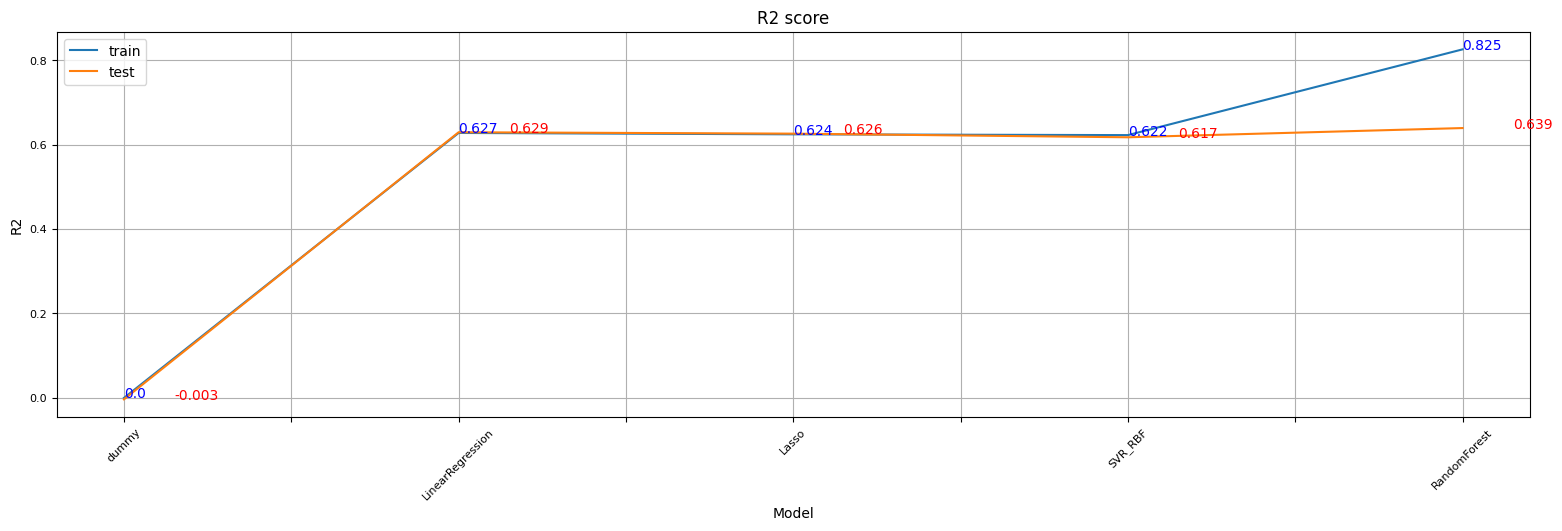

In [ ]:

scores_map_train = pd.DataFrame(train_score,index=['train']).transpose()
scores_map_test = pd.DataFrame(test_score,index=['test']).transpose()
scores_map_both = scores_map_train.join(scores_map_test)
fig ,ax = plt.subplots(figsize=(19,5) )
scores_map_both.plot(ax=ax, grid=True)
rows, cols = scores_map_both.shape
offset = 0 
color='blue'
for col in range(cols):
    for i in range(rows):
        ax.annotate('{}'.format(round(scores_map_both.iloc[i, col],3)), xy=(i + offset, scores_map_both.iloc[i, col]),color =color) 
    offset = 0.15
    color='red'
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Model')
plt.ylabel("R2")
plt.title("R2 score")
plt.show()


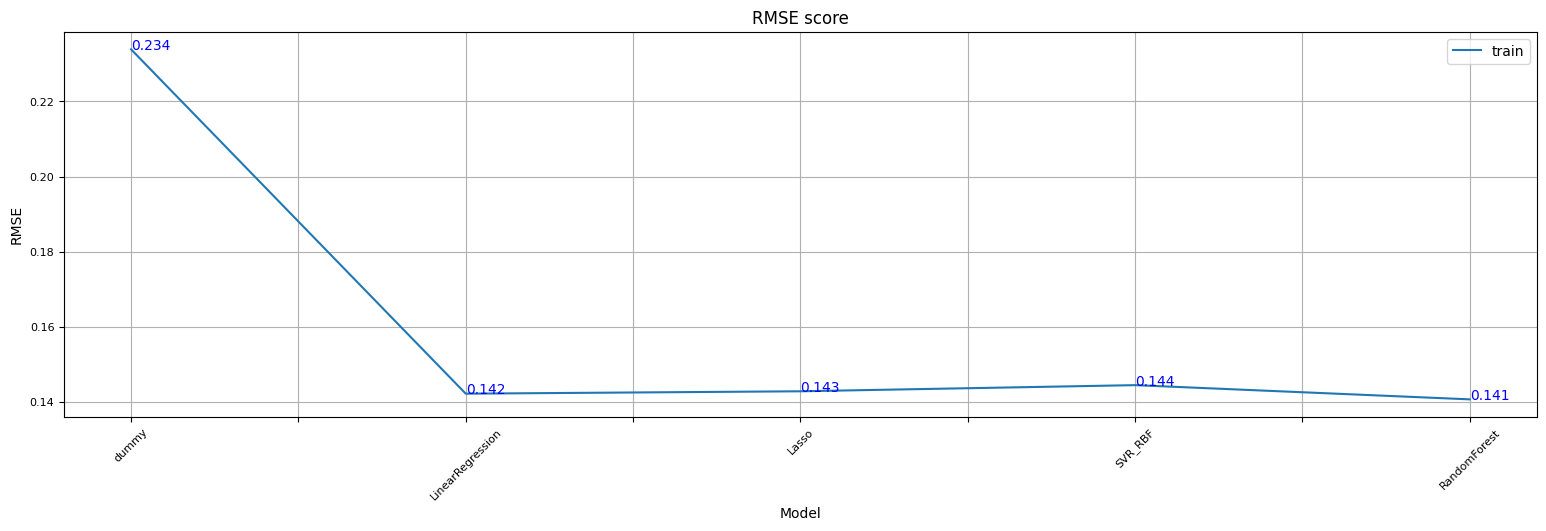

In [49]:
rmse = pd.DataFrame(rmse_score,index=['train']).transpose()
fig ,ax = plt.subplots(figsize=(19,5) )
rmse.plot(ax=ax, grid=True)
rows, cols = rmse.shape
offset = 0 
color='blue'
for col in range(cols):
    for i in range(rows):
        ax.annotate('{}'.format(round(rmse.iloc[i, col],3)), xy=(i + offset, rmse.iloc[i, col]),color =color) 
    offset = 0.15
    color='red'
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Model')
plt.ylabel("RMSE")
plt.title("RMSE score")
plt.show()


There is a clear **over-fitting** on the **RandomForest model**. This might be linked to the depth and number of tree selected during hyperparameters fitting. Moreover the training set is not that large (around 100 individuals) and ensemble learning methods require important amount of data to be trained. 

However RandomForest is the one achieving the best R2 score on the testing set. 

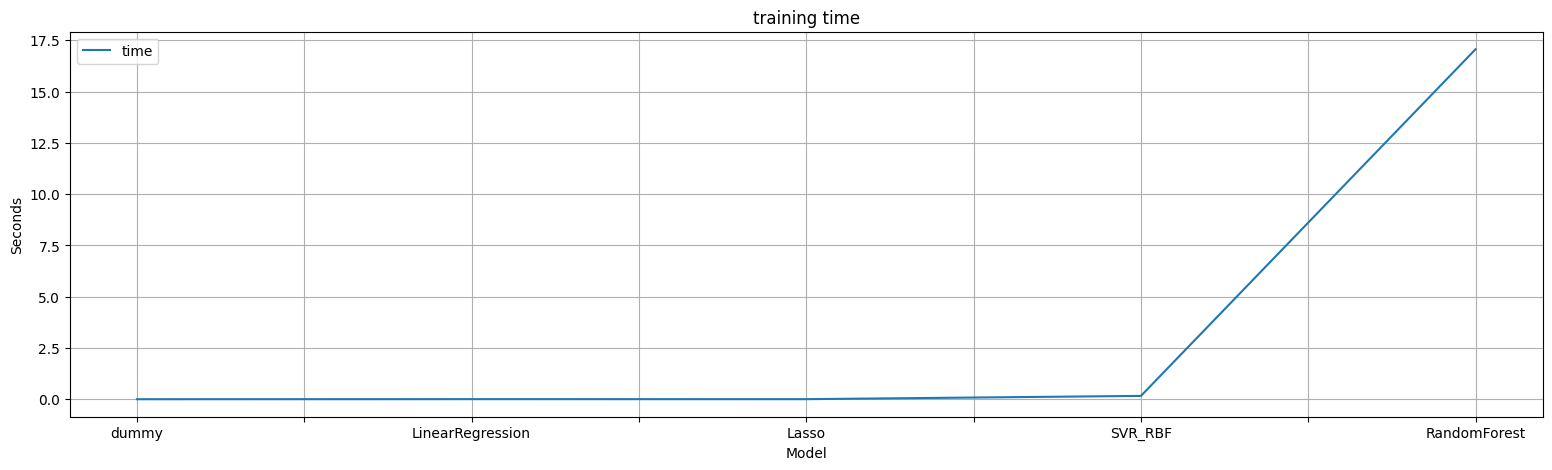

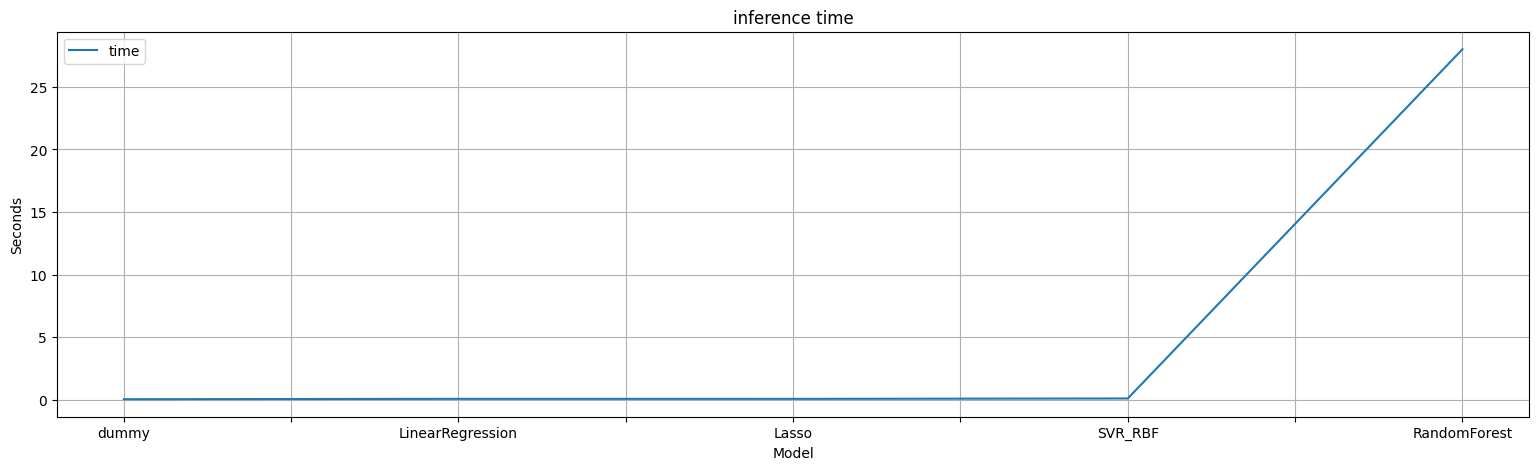

In [ ]:
train_time = pd.DataFrame(training_time,index=['time']).transpose()
inf_time = pd.DataFrame(inference_time,index=['time']).transpose()
train_time.plot(figsize=(19,5) , grid=True)
plt.xlabel('Model')
plt.ylabel("Seconds")
plt.title("training time")

inf_time.plot(figsize=(19,5) , grid=True)
plt.xlabel('Model')
plt.title("inference time")
plt.ylabel("Seconds")
plt.show()


RandomForest model takes 10 times  the time of other models for the inference. Therefore we will second best model in terms of R2 score which is the **Linear Regression**

# IV. Interpretability

Let's study the interpretability of **the Linear Regression**. 

In [ ]:
shap.initjs()

In [ ]:
reg = LinearRegression().fit(X_train,y_train)

In [ ]:
sample_idx = 0
# lin_reg_explainer1 = shap.LinearExplainer(reg, X_train)
# shap_vals = lin_reg_explainer1.shap_values(X_test.iloc[0])
lin_reg_explainer2 = shap.LinearExplainer(reg, X_train, feature_perturbation="correlation_dependent")
shap_vals = lin_reg_explainer2.shap_values(X_test.iloc[0].values.reshape(1,-1))[0]



Estimating transforms: 100%|██████████| 1000/1000 [00:04<00:00, 240.22it/s]


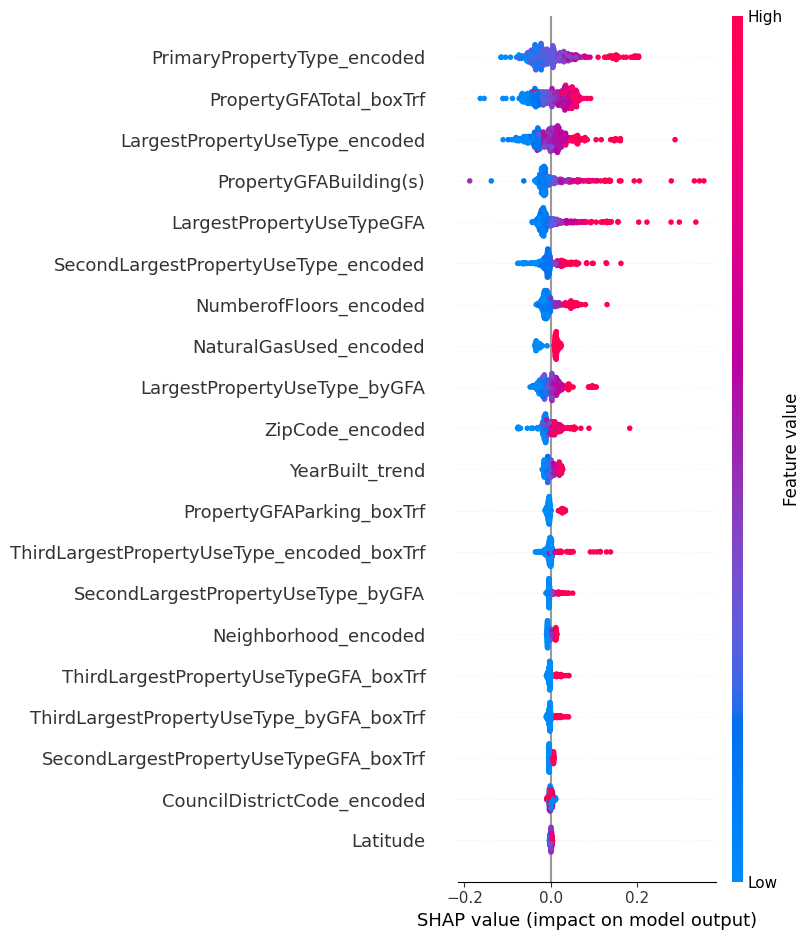

In [ ]:
shap_values = lin_reg_explainer2(X_test)
shap.summary_plot(shap_values, X_test)

The SHAP values is based on game theory. It  explains the most important feature and their effect on the target. 
The above plot combines feature importance and effects
For the plot above, I get insights of the model's predictions : 
- the primary property type has the strongest effect on the energy consumption 
- As the building is bigger (in surface with total and property GFA) the consumption is more likely to be high. 
- The zipCode feature is more likely to have an effect on the target then the CouncilDistrictCode or the Latitude and Longitude. 
